### Changes from run-1

#### Test data
* Previously we used cross-validation to select the best model, and tested that model on data (opus 131) that we had kept apart from the beginning.
* The scores achieved when predicting on opus 131 were our final results.
* This time we train/validate on all data and take the final cross-validation scores as our results.

#### Crossvalidation
* Previously we simply took all sequences in the train/validate set, shuffled them and trained/validated with a 80/20 split.
* This time we instead shuffle the opuses (opi?) before generating the sequences, with the idea that this could hint at how patterns generalize across opuses with. So we basically have leave one (opus) out cross validation.

#### Input
* Previously we grouped similar chords together and grouped chords that appeared rarely (less than 10 times) under a single label.
* The idea was to remove outliers, reduce the output space and improve generalization
* As it was indicated that having the amount of output classes be dependent on the input was a bad idea we now use rules independent of the data for grouping and have ~800 classes instead of ~100

#### Model
* Previously we had a bi-directional LSTM layer in the model architecture as it increased performance. For the sake of being able to compare the results to a simple N-gram model we decided to remove that layer in this iteration.

#### Hyperparameters
* Given the increased amount of outliers and the removal of the bidirectional layer we expect generalization accuracy to decrease.
* To remedy that we used the current model and iterated through different values for a regularization parameter, which we didn't explore previously.
* Best scores were obtained with regstrength = 0 however.


In [2]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
sns.set()

from tensorflow.keras import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

from chord_functions import *


/home/sigis/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Setup

In [26]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

#Load all data
data = pd.read_csv('data/820chords.csv')

#Remove redundant attributes. Keep op to split into opuses
data = data[['chord', 'op']]

#Use dummy variable representation for the chords
data = pd.get_dummies(data)

# Model

In [27]:
def lstm(lstm_x, lstm_y, optimizer, loss, metrics, regstrength):
    model = Sequential()
    
    model.add(LSTM(256, return_sequences=True, input_shape=(lstm_x.shape[1], lstm_x.shape[2]),\
                   kernel_regularizer=regularizers.l2(regstrength)))
    
    model.add(Dropout(0.5))

    model.add(LSTM(64, return_sequences=False,\
              kernel_regularizer=regularizers.l2(regstrength)))
    
    model.add(Dropout(0.3))
    
    model.add(Dense(lstm_y.shape[1], activation='softmax', \
             kernel_regularizer=regularizers.l2(regstrength)))

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

# Train/Test

### Select parameters for the learning process

In [28]:
optimizer = 'Adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']
epochs = 30
verbose = 2
seq_length = 10

#Save the weights whenever validation accuracy is increased
checkpoint = ModelCheckpoint(
    'weights.{epoch:02d}-{val_acc:.4f}.hdf5',
    monitor='val_acc', 
    verbose=0,        
    save_best_only=False
)
# Stop the learning process if we havent improved validation accuracy for 10 epochs
earlystop = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1)

#callbacks_list = [checkpoint, earlystop]   
callbacks_list = [earlystop]  

### Cross validate

In [5]:
#define the range of regularization strengths to check
regstrength = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
print("Start!")

#Create container for results
RESULTS = pd.DataFrame()

for strength in regstrength:
    print("\nChecking regstrength {}".format(strength))
    cv_results = pd.DataFrame()
    
    #Cross validate on each opus
    for opus in data['op'].unique():
        print("\nValidating on opus {}".format(opus))

        #Split into training and validation
        valid = data[data['op'] == opus]
        train = data[data['op'] != opus]

        #Drop the opus attribute since it's no longer needed
        valid = valid.drop(columns='op')
        train = train.drop(columns='op')

        #Generate sequences from the data
        valid_in, valid_out = generate_sequences(valid, valid, seq_length)
        train_in, train_out = generate_sequences(train, train, seq_length)

        #Create model
        model = lstm(train_in, train_out, optimizer, loss, metrics, strength)

        #Train on the folds
        model.fit(train_in,
                  train_out,
                  epochs = epochs,
                  verbose = verbose,
                  validation_data = (valid_in, valid_out),
                  callbacks = callbacks_list)

        #Save the history object for the model, appending test opus and regstrength
        history = pd.DataFrame(model.history.history)
        history.index.name = 'epoch'
        history['opus'] = opus
        history['reg'] = strength
        cv_results = cv_results.append(history)
    
    RESULTS = RESULTS.append(cv_results)

print("Done!")
BACKUP = RESULTS
pd.DataFrame.to_csv(BACKUP, './results/BACKUP.csv')

Start!

Checking regstrength 0

Validating on opus 127
Train on 25863 samples, validate on 2210 samples
Epoch 1/30
 - 156s - loss: 4.0774 - acc: 0.1196 - val_loss: 4.1609 - val_acc: 0.1253
Epoch 2/30
 - 156s - loss: 3.9651 - acc: 0.1245 - val_loss: 4.1684 - val_acc: 0.1253
Epoch 3/30
 - 153s - loss: 3.9606 - acc: 0.1257 - val_loss: 4.1837 - val_acc: 0.1253
Epoch 4/30
 - 156s - loss: 3.9521 - acc: 0.1265 - val_loss: 4.1703 - val_acc: 0.1253
Epoch 5/30
 - 149s - loss: 3.9519 - acc: 0.1277 - val_loss: 4.1854 - val_acc: 0.1253
Epoch 6/30
 - 149s - loss: 3.9484 - acc: 0.1270 - val_loss: 4.1873 - val_acc: 0.1253
Epoch 00006: early stopping

Validating on opus 130
Train on 25609 samples, validate on 2464 samples
Epoch 1/30
 - 150s - loss: 4.1173 - acc: 0.1189 - val_loss: 3.7201 - val_acc: 0.1530
Epoch 2/30
 - 148s - loss: 4.0046 - acc: 0.1227 - val_loss: 3.7432 - val_acc: 0.1530
Epoch 3/30
 - 148s - loss: 3.9974 - acc: 0.1253 - val_loss: 3.7355 - val_acc: 0.1530
Epoch 4/30
 - 148s - loss: 3.9

Epoch 20/30
 - 138s - loss: 3.0211 - acc: 0.2802 - val_loss: 3.8871 - val_acc: 0.2081
Epoch 21/30
 - 139s - loss: 2.9544 - acc: 0.2908 - val_loss: 3.9298 - val_acc: 0.1984
Epoch 22/30
 - 139s - loss: 2.8910 - acc: 0.3009 - val_loss: 3.9916 - val_acc: 0.1923
Epoch 23/30
 - 138s - loss: 2.8284 - acc: 0.3142 - val_loss: 4.0329 - val_acc: 0.1869
Epoch 24/30
 - 138s - loss: 2.7660 - acc: 0.3216 - val_loss: 4.0875 - val_acc: 0.1869
Epoch 25/30
 - 138s - loss: 2.7001 - acc: 0.3317 - val_loss: 4.1294 - val_acc: 0.1838
Epoch 00025: early stopping

Validating on opus 74
Train on 26558 samples, validate on 1515 samples
Epoch 1/30
 - 160s - loss: 4.0954 - acc: 0.1210 - val_loss: 3.8079 - val_acc: 0.1406
Epoch 2/30
 - 156s - loss: 3.9852 - acc: 0.1225 - val_loss: 3.8016 - val_acc: 0.1406
Epoch 3/30
 - 156s - loss: 3.9804 - acc: 0.1257 - val_loss: 3.8097 - val_acc: 0.1406
Epoch 4/30
 - 156s - loss: 3.9787 - acc: 0.1279 - val_loss: 3.8232 - val_acc: 0.1406
Epoch 5/30
 - 155s - loss: 3.9772 - acc: 0.1

Epoch 4/30
 - 156s - loss: 4.0636 - acc: 0.1253 - val_loss: 3.7646 - val_acc: 0.0954
Epoch 5/30
 - 156s - loss: 4.0624 - acc: 0.1232 - val_loss: 3.7766 - val_acc: 0.1530
Epoch 6/30
 - 156s - loss: 4.0603 - acc: 0.1242 - val_loss: 3.7966 - val_acc: 0.0954
Epoch 00006: early stopping

Validating on opus 131
Train on 25519 samples, validate on 2554 samples
Epoch 1/30
 - 165s - loss: 4.4184 - acc: 0.1192 - val_loss: 4.0115 - val_acc: 0.1316
Epoch 2/30
 - 155s - loss: 4.0570 - acc: 0.1241 - val_loss: 3.9921 - val_acc: 0.1316
Epoch 3/30
 - 155s - loss: 4.0466 - acc: 0.1261 - val_loss: 4.0185 - val_acc: 0.1316
Epoch 4/30
 - 155s - loss: 4.0450 - acc: 0.1265 - val_loss: 4.0183 - val_acc: 0.1316
Epoch 5/30
 - 155s - loss: 4.0389 - acc: 0.1262 - val_loss: 4.0177 - val_acc: 0.1316
Epoch 6/30
 - 155s - loss: 4.0387 - acc: 0.1270 - val_loss: 4.0131 - val_acc: 0.1316
Epoch 00006: early stopping

Validating on opus 132
Train on 25649 samples, validate on 2424 samples
Epoch 1/30
 - 167s - loss: 4.3735

Epoch 6/30
 - 130s - loss: 4.1393 - acc: 0.1217 - val_loss: 3.9602 - val_acc: 0.1432
Epoch 00006: early stopping

Validating on opus 59
Train on 22514 samples, validate on 5559 samples
Epoch 1/30
 - 161s - loss: 4.6785 - acc: 0.1312 - val_loss: 4.1330 - val_acc: 0.1049
Epoch 2/30
 - 142s - loss: 4.1045 - acc: 0.1331 - val_loss: 4.1173 - val_acc: 0.1049
Epoch 3/30
 - 142s - loss: 4.0955 - acc: 0.1343 - val_loss: 4.1117 - val_acc: 0.1049
Epoch 4/30
 - 142s - loss: 4.0844 - acc: 0.1339 - val_loss: 4.1087 - val_acc: 0.1049
Epoch 5/30
 - 142s - loss: 4.0765 - acc: 0.1343 - val_loss: 4.1149 - val_acc: 0.1049
Epoch 6/30
 - 142s - loss: 4.0707 - acc: 0.1339 - val_loss: 4.1230 - val_acc: 0.1049
Epoch 00006: early stopping

Validating on opus 74
Train on 26558 samples, validate on 1515 samples
Epoch 1/30
 - 182s - loss: 4.6054 - acc: 0.1239 - val_loss: 3.9302 - val_acc: 0.1406
Epoch 2/30
 - 161s - loss: 4.1135 - acc: 0.1249 - val_loss: 3.9386 - val_acc: 0.1406
Epoch 3/30
 - 161s - loss: 4.1049 -

Epoch 2/30
 - 158s - loss: 4.5305 - acc: 0.1258 - val_loss: 4.2249 - val_acc: 0.1530
Epoch 3/30
 - 158s - loss: 4.4346 - acc: 0.1266 - val_loss: 4.1492 - val_acc: 0.0954
Epoch 4/30
 - 158s - loss: 4.3584 - acc: 0.1253 - val_loss: 4.1046 - val_acc: 0.1530
Epoch 5/30
 - 158s - loss: 4.2985 - acc: 0.1265 - val_loss: 4.0362 - val_acc: 0.1530
Epoch 6/30
 - 158s - loss: 4.2470 - acc: 0.1252 - val_loss: 3.9938 - val_acc: 0.1530
Epoch 00006: early stopping

Validating on opus 131
Train on 25519 samples, validate on 2554 samples
Epoch 1/30
 - 190s - loss: 7.9604 - acc: 0.1267 - val_loss: 4.4819 - val_acc: 0.1316
Epoch 2/30
 - 158s - loss: 4.5101 - acc: 0.1268 - val_loss: 4.3822 - val_acc: 0.1316
Epoch 3/30
 - 158s - loss: 4.4154 - acc: 0.1274 - val_loss: 4.3322 - val_acc: 0.1316
Epoch 4/30
 - 158s - loss: 4.3367 - acc: 0.1276 - val_loss: 4.2714 - val_acc: 0.1316
Epoch 5/30
 - 158s - loss: 4.2748 - acc: 0.1268 - val_loss: 4.2357 - val_acc: 0.1316
Epoch 6/30
 - 158s - loss: 4.2243 - acc: 0.1278 -

Epoch 4/30
 - 137s - loss: 4.6497 - acc: 0.1228 - val_loss: 4.4328 - val_acc: 0.1432
Epoch 5/30
 - 131s - loss: 4.4964 - acc: 0.1228 - val_loss: 4.3113 - val_acc: 0.1051
Epoch 6/30
 - 132s - loss: 4.3798 - acc: 0.1229 - val_loss: 4.2002 - val_acc: 0.1432
Epoch 00006: early stopping

Validating on opus 59
Train on 22514 samples, validate on 5559 samples
Epoch 1/30
 - 189s - loss: 23.8109 - acc: 0.1342 - val_loss: 5.2206 - val_acc: 0.1049
Epoch 2/30
 - 144s - loss: 4.9877 - acc: 0.1352 - val_loss: 4.8969 - val_acc: 0.1049
Epoch 3/30
 - 144s - loss: 4.7059 - acc: 0.1349 - val_loss: 4.6324 - val_acc: 0.1049
Epoch 4/30
 - 144s - loss: 4.5010 - acc: 0.1344 - val_loss: 4.4866 - val_acc: 0.1049
Epoch 5/30
 - 144s - loss: 4.3532 - acc: 0.1352 - val_loss: 4.3577 - val_acc: 0.1049
Epoch 6/30
 - 144s - loss: 4.2450 - acc: 0.1351 - val_loss: 4.2386 - val_acc: 0.1049
Epoch 00006: early stopping

Validating on opus 74
Train on 26558 samples, validate on 1515 samples
Epoch 1/30
 - 207s - loss: 20.9321

# Results

### Restore result from backup

In [109]:
RESULTS = pd.read_csv('results/BACKUP.csv')
RESULTS = RESULTS.set_index(['reg','opus'])

### For each regularization value, calculate the average weighed cross-validated score and output it

In [120]:
AVERAGES = pd.DataFrame()

#For each level of regularization
for regularization, cvscores in RESULTS.groupby(level=0):
    average = pd.DataFrame()
    
    #Iterate through all folds and extract the highest weighed validation scores
    for opus, fold in cvscores.groupby(level=1):
        
        #Weigh all metrics by the amount of chords in the opus validated on
        #weight = (data[data['op'] == opus]).shape[0]
        #fold = fold[['val_loss', 'val_acc', 'loss', 'acc']] * weight
        
        #Retrieve the best score
        best = fold[fold['val_acc'] == fold['val_acc'].max()]
        average = average.append(best)
    
    #Make a pretty dataframe of the mean
    average = average.describe().loc[['mean']]
    average = average.rename(index={'mean': regularization})
    
    #Take the mean scores for this regularization value and store them in AVERAGE for comparisons
    AVERAGES = AVERAGES.append(average)

BEST = AVERAGES[AVERAGES['val_acc'] == AVERAGES['val_acc'].max()]

print("Full table of cross validated scores for each regularization value")
display(AVERAGES)

print("Best score")
display(BEST)

Full table of cross validated scores for each regularization value


,epoch,val_loss,val_acc,loss,acc
0.000,3.641026,4.167775,0.131346,3.936454,0.133513
0.001,2.528302,4.103910,0.127975,4.055110,0.124874
0.005,2.404255,4.172407,0.129148,4.106369,0.124472
0.010,2.490196,4.194825,0.127646,4.183819,0.126107
0.050,2.500000,4.366877,0.127714,4.586606,0.127213
0.100,2.622642,4.457916,0.127237,4.910315,0.127721
0.500,2.400000,4.655938,0.126000,7.689694,0.128297


Best score


,epoch,val_loss,val_acc,loss,acc
0.0,3.641026,4.167775,0.131346,3.936454,0.133513


# Graphs

### Unweighed validation accuracy for each opus

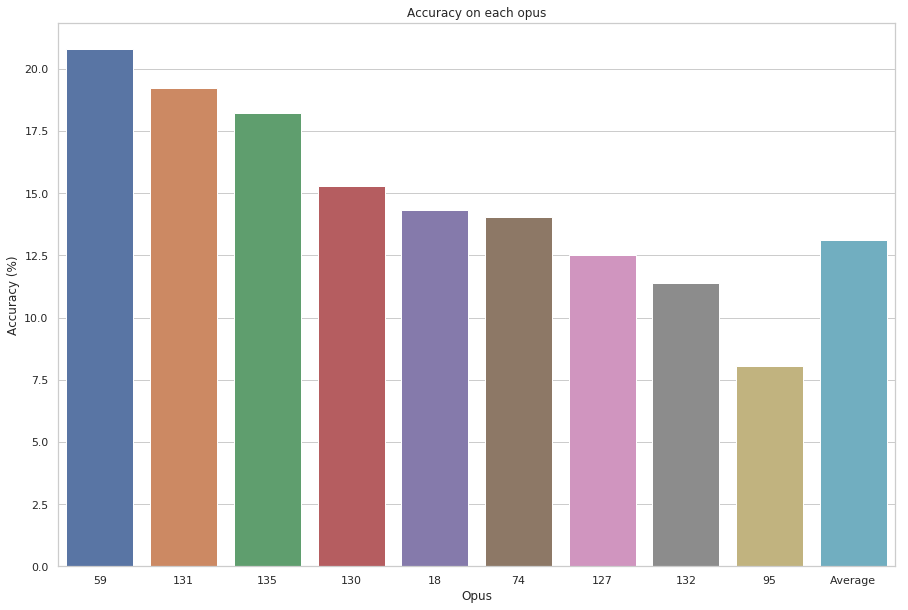

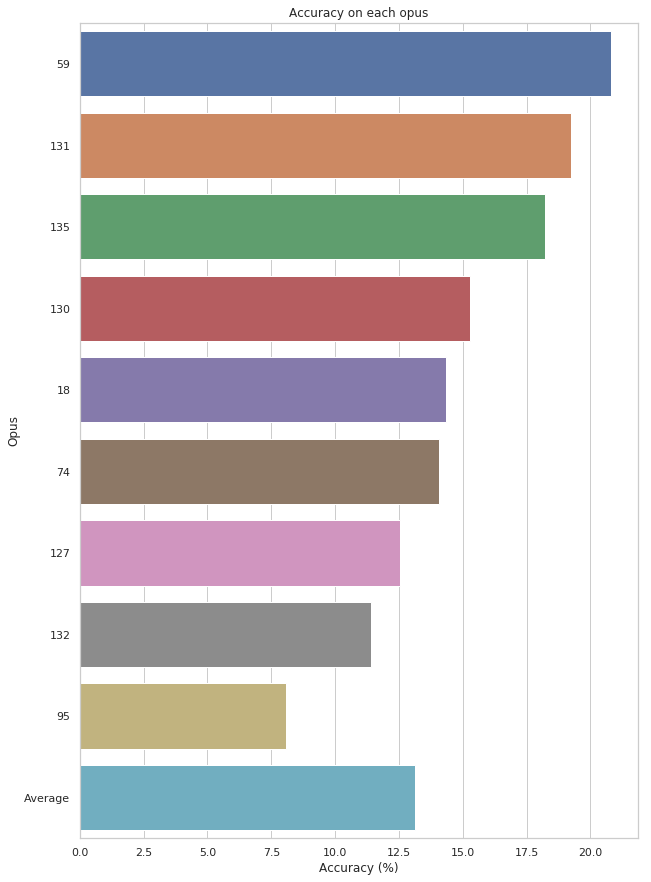

In [216]:
# Select the data from the reg_value that produced the best results
best_reg = BEST.index.values[0]
df = RESULTS.loc[best_reg]

#For each of the nine folds/opuses...
scores = pd.DataFrame()
for opus, fold in df.groupby(level=0):
        
        #Drop potential duplicate values
        fold = fold.drop_duplicates(subset='val_acc')
        
        #Retrieve the scores when the val_acc was highest
        valacc = fold[fold['val_acc'] == fold['val_acc'].max()]
        
        #Store
        scores = scores.append(valacc)

#Sort scores by valacc
scores = scores.sort_values(by='val_acc', ascending=False)

#Append the average score to the individual scores
avg = BEST.rename(index={best_reg: 'Average'})
scores = scores.append(avg)

sns.set_style("whitegrid")

#Plot them
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=scores[['val_acc']].T)
ax.set_title("Accuracy on each opus")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Opus")
ax.set_yticklabels(np.around(ax.get_yticks()* 100,2))

fig, ax = plt.subplots(figsize=(10,15))
sns.barplot(data=scores[['val_acc']].T, orient='horizontal')
ax.set_title("Accuracy on each opus")
ax.set_xlabel("Accuracy (%)")
ax.set_ylabel("Opus")
ax.set_xticklabels(np.around(ax.get_xticks()* 100,2))
plt.show()

In [ ]:
#Weigh all metrics by the amount of chords in the opus validated on
#weight = (data[data['op'] == opus]).shape[0]
#fold = fold[['val_loss', 'val_acc', 'loss', 'acc']] * weight